# Data Pipeline on the Cloud

## Introduction

Gans is a young startup company whose service is to provide e-Scooters.
With the goal of reducing costs, a team of data engineers was tasked with finding ways to distribute scooters more efficiently.

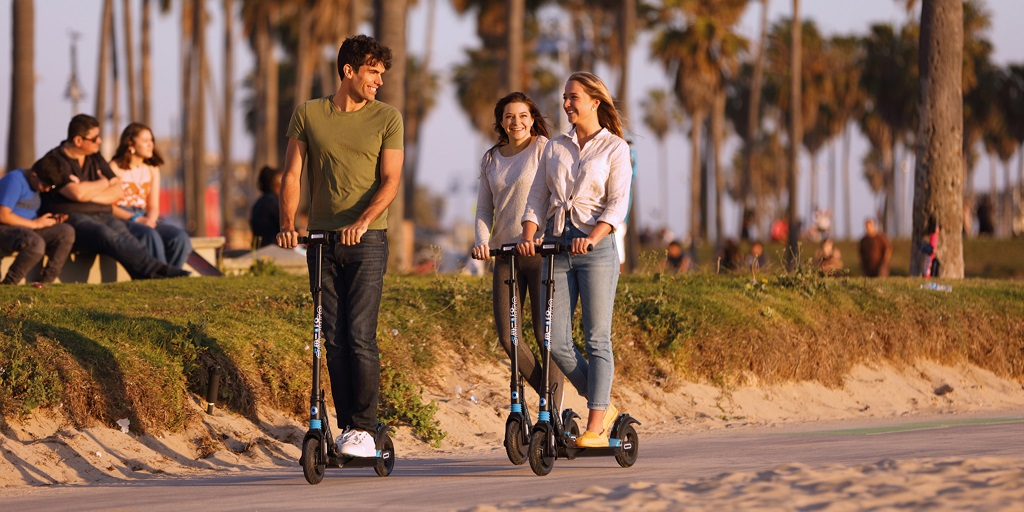

The idea was that if they knew where the scooters would be needed next, then Gans could dynamically discount specific areas in order to encourage customers to park the scooters in locations where usage was expected to be high.

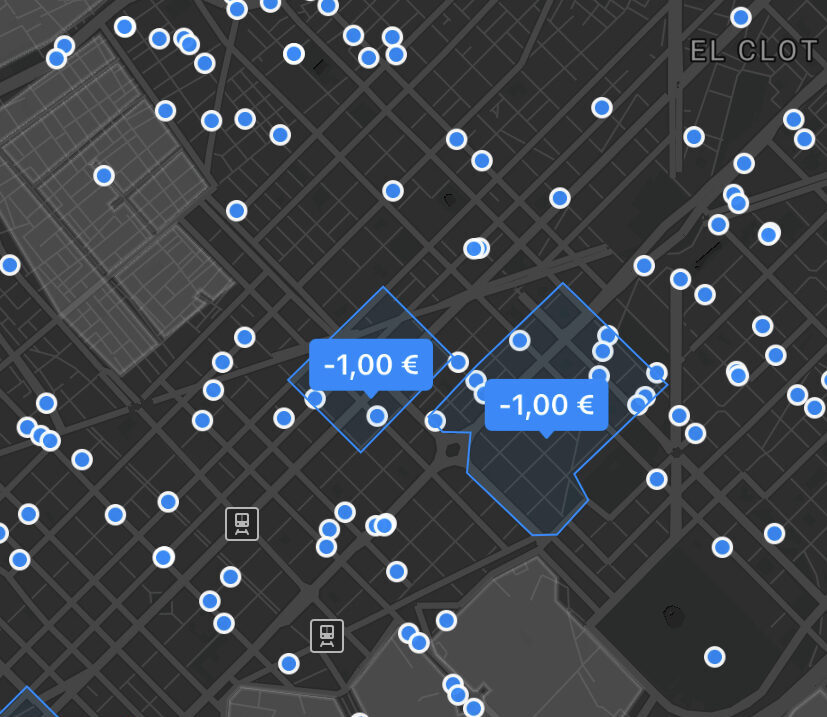

Under what circumstances can the use of the scooters be predicted? The project team's answer was: In all cases where the customer needs an e-scooter for travel to or from an airport or train station.
**In this project, the focus was on the consideration of airports.** The more flights arriving or departing every hour should determine how high the expected utilization will be.

## Objective

To enable the determination of customer volume, an automatic data pipeline is to be created that retrieves the necessary data and then stores it in a database.

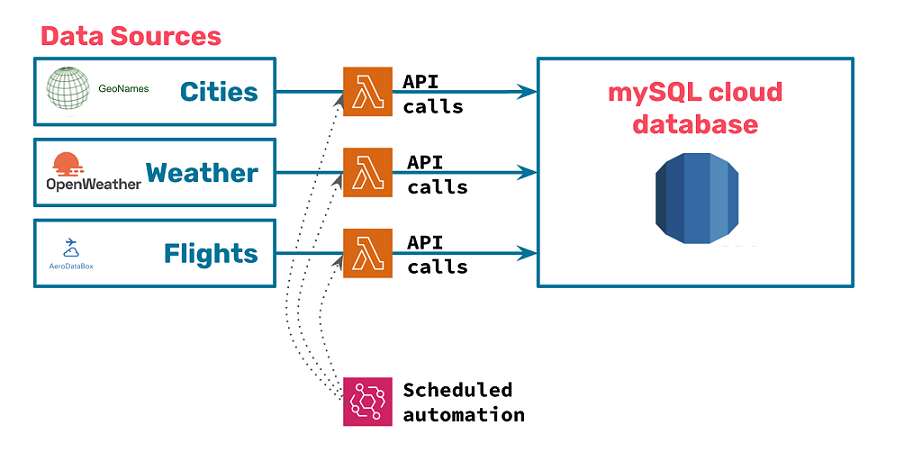

The team began by determining what data would be needed to be able to build a database on which all predictions would be based. Besides the obviously necessary information like:

*   Which cities?
*   Which airports?
*   How many arrivals/departures?  

**weather data** was also included. The reason for this is that experience has shown that the use of e-scooters is also strongly dependent on weather.  
The project implementation was divided into the following steps:

1.   Create a database schema
2.   Insert the schema into a database instance  provided by Amazon's Relational Database Service (RDS)
3.   Collect static data (cities & airports)
4.   Create Python scripts which can collect dynamic data (flights & weather) using APIs
6.   Insert the scripts into the cloud using AWS' Lambda Function feature
7.   Schedule the scripts to be executed periodically

## Impementation

### 1. Create a database schema

The MySQL Workbench software can be used to design a data structure in a Local Instance that can store all the required data and determine its relations.

``` mysql

CREATE DATABASE gans;
USE gans;


CREATE TABLE IF NOT EXISTS cities (
	city_id INT,
    city VARCHAR(200),
    country VARCHAR(200),
    country_code CHAR(2),
    population INT,
    time_zone INT,
    latitude FLOAT,
    longitude FLOAT,
   	PRIMARY KEY(city_id)
);

SELECT * FROM cities;


CREATE TABLE IF NOT EXISTS weathers (
	weather_id INT auto_increment,
    city_id INT,
    time_utc INT,
    local_time CHAR(20),
    temperature FLOAT,
    humidity FLOAT,
    cloudiness_pc INT,
    wind_speed FLOAT,
    precipitation_prob FLOAT,
    rain_volume FLOAT,
    snow_volume FLOAT,
    PRIMARY KEY(weather_id),
    FOREIGN KEY(city_id) REFERENCES cities(city_id)
);

SELECT * FROM weathers;



CREATE TABLE IF NOT EXISTS airports (
	city_id INT,
    lat FLOAT,
    lon FLOAT,
    icao CHAR(4),
    iata CHAR(3),
    name VARCHAR(200),
    PRIMARY KEY(icao),
    FOREIGN KEY(city_id) REFERENCES cities(city_id)
);

SELECT * FROM airports;




CREATE TABLE IF NOT EXISTS flights (
	flights_id INT auto_increment,
    icao CHAR(4),
    date CHAR(10),
    hour_day CHAR(5),
    num_of_arriv INT,
    num_of_depart INT,
    PRIMARY KEY(flights_id),
    FOREIGN KEY(icao) REFERENCES airports(icao)
);

SELECT * FROM flights;
```

This code defines a database with the following four tables:

*   cities
*   airports
*   flights
*   weather

Furthermore, the code defines a primary key for each table. Two of these primary keys are used as foreign keys in other tables. The ```city_id```-**key** is used to create relations between the ```cities```-**table** and the ```weather```-**table** as well as the ```airports```-**table**. The ```icao```-**key** connects the ```airports```-**table** with the ```flights```-**table**.

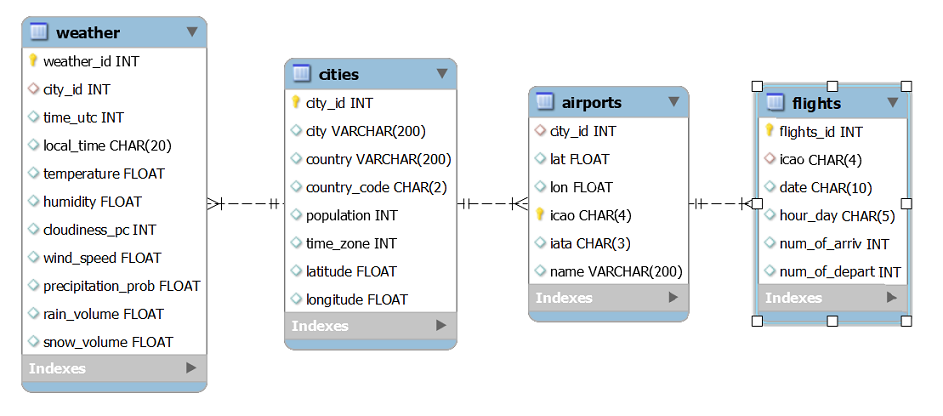

The picture shown above graphically represents these four tables and their relations. The primary keys are indicated by the yellow symbols. Foreign keys are indicated by the pink diamonds. *Every foreign key is a primary key of another table*.

### 2. Insert the schema into a database instance provided by Amazon's RDS

Amazon's RDS is a service that simpliflies the setup of a relational database. In this case we were able to use the free tier template which does not create any cost.  
As soon as the instance is running, it will be ready for beeing connected to the database-template that has been created locally using MySQL Workbench. The next step is to establish a connection that links the local database template to the RDS instance, that has been created using the AWS.

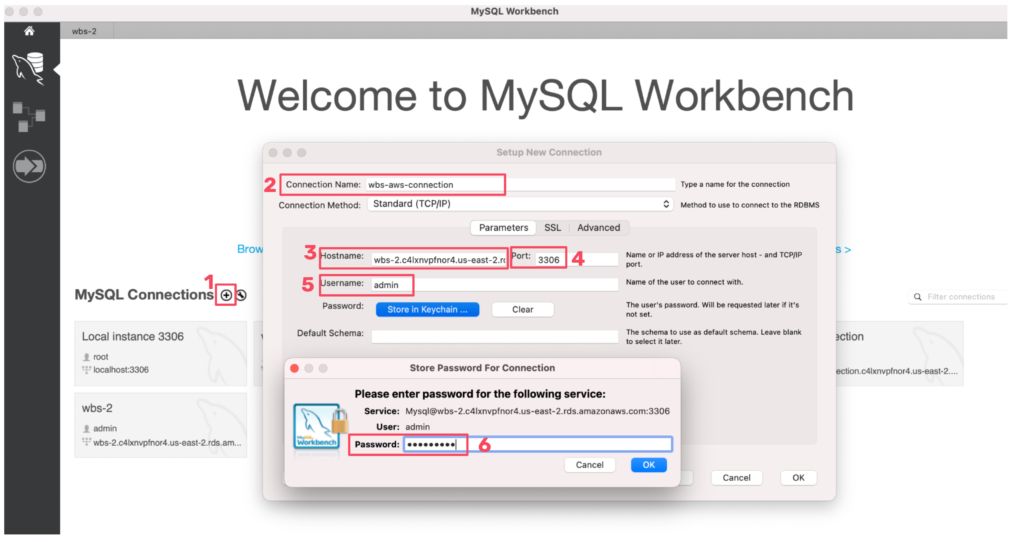

**NOTE:** In order to work correctly it is required to ***explecitly allow traffic*** that will be created by any connection source which is trying to interact with the databse. Do this On the AWS platform inside the *Connectivity & Security*-tab of the RDS-instance.

### 3. Collect static data (cities & airports)

#### Pre-requirements

In order to work with an API, a user account and subscription is usually required. To collect cities and airport data, the following two API services were used:
1. GeoNames geographical database API service (For further information, please visit their [Webpage](https://www.geonames.org/))
2. RapidAPI Airports and Flights database API service (For further information, please visit their [Webpage](https://rapidapi.com/))  

In addition the [```world_cities.csv```](https://public.opendatasoft.com/explore/dataset/geonames-all-cities-with-a-population-1000/table/?disjunctive.cou_name_en&sort=name&location=2,0.90932,0.12126&basemap=jawg.light) is required.

#### Data collection


The team decided to initially focus on a small selection of cities. The ```EuroCitiesPopulation15_.csv``` shown below represents this selection.
##### ```EuroCitiesPopulation15_.csv```

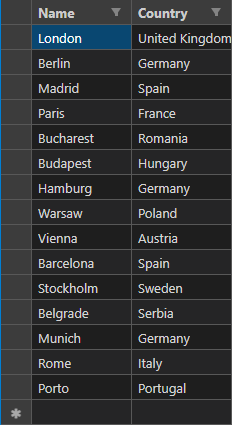

##### Cities
The following Python code produces the ```cities.csv``` which then will be inserted into the data base.

```python
import geocoder
import pandas as pd

wc = pd.read_csv('world_cities.csv')
countries= pd.read_csv('EuroCitiesPopulation15_.csv').country
cities = pd.read_csv('EuroCitiesPopulation15_.csv').name

city_id=[]
for co,ci in zip(countries,cities):
    city_id=city_id+[(wc.set_index('country').loc[co].set_index('name').loc[ci].geonameid)]
    
    
lat=[]
lng=[]
population=[]
country_code=[]
time_zone=[]
east=[]
south=[]
north=[]
west=[]

for c in city_id:

    # DATA COLLECTION:

    g = geocoder.geonames(c, method='details', key='CENSORED')
    lat             = lat+[(g.geojson['features'][0]['properties']['lat'])]
    lng             = lng+[(g.geojson['features'][0]['properties']['lng'])]
    population      = population+[(g.geojson['features'][0]['properties']['population'])]
    country_code    = country_code+[(g.geojson['features'][0]['properties']['country_code'])]
    time_zone       = time_zone+[3600*(g.geojson['features'][0]['properties']['raw']['timezone']['gmtOffset'])]
    east            = east+[(g.geojson['features'][0]['properties']['raw']['bbox']['east'])]
    south           = south+[(g.geojson['features'][0]['properties']['raw']['bbox']['south'])]
    north           = north+[(g.geojson['features'][0]['properties']['raw']['bbox']['north'])]
    west            = west+[(g.geojson['features'][0]['properties']['raw']['bbox']['west'])]  
    
cities_dic = {'city_id': city_id,
              'city': cities, 
              'country':countries, 
              'Code': country_code, 
              'Population': population, 
              'Time_Zone': time_zone, 
              'Latitud': lat, 
              'Logitud': lng, 
              'East': east, 
              'South': south, 
              'North': north, 
              'West': west}
cities_df  = pd.DataFrame.from_dict(cities_dic)
cities_df.to_csv('cities.csv', index=False)
```
1. The 15 cities are searched in the ```cities.csv``` and their respective ```geonameid```'s are retrieved.
2. Using the ```geonameid```'s the respective geographical information is retrieved in the form of ```.json```-files.
3. Finally the ```cities_df``` dataframe is created and gets written into the ```cities.csv``` file.

##### Airports
The following Python code produces the ```airports.csv``` which then will be inserted into the data base.

```python
import requests
import datetime
import pandas as pd
import numpy as np

cities_df = pd.read_csv('cities.csv')
cities = cities_df['city']

airports = pd.DataFrame(columns=['city','city_id','lat','lon','icao','iata','name'])


for city in cities:
    lat = float(cities_df.loc[cities_df['city']==city]['Latitud'])
    lon = float(cities_df.loc[cities_df['city']==city]['Logitud'])

    url = f"https://aerodatabox.p.rapidapi.com/airports/search/location/{lat}/{lon}/km/50/16"
    
    querystring = {"withFlightInfoOnly":"0"}
    
    headers = {
            	"X-RapidAPI-Key": "2ef471dfcbmshec01fd033aae0e3p10a740jsn9a6d81f2bead",
            	"X-RapidAPI-Host": "aerodatabox.p.rapidapi.com"
            }
    
    response = requests.request("GET", url, headers=headers)#, params=querystring)
    print('Status code',response.status_code)
    airp_js = response.json()
    
    for a in airp_js["items"]:
        airports = airports.append({'city':city,
                      'city_id': cities_df[cities_df['city']==city].city_id.iloc[0],
                      'lat':a["location"]["lat"],
                      'lon':a["location"]["lon"],
                      'icao':a["icao"],
                      'iata':a["iata"],
                      'name':a["name"]
                      }
                      ,ignore_index=True)

        
airports.to_csv('airports_new.csv', index=False)
```
1. The ```airports``` data frame gets created containig the columns:

 * ```city```
 * ```city_id```
 * ```lat```
 * ```lon```
 * ```icao```
 * ```iata```
 * ```name```
2. Using the previously created ```cities.csv``` the information for the respective cities gets requested from the RapidAPI.
3. The ```airports_new.csv``` gets created using the airports data frame.

### 4. Create Python scripts which can collect dynamic data (flights & weather) using APIs

#### Pre-requirements

To collect flights and weather data, the following two API services were used:
1. The [AeroDataBox API](https://rapidapi.com/aedbx-aedbx/api/aerodatabox/) from RapidAPI
2. The [OpenWeather API](https://openweathermap.org/api)

#### Flights data
The following Python code fetches the *flights* data and pushes it directly into the data base.

```python
import requests
import datetime
import pandas   as pd
import numpy    as np
import config   as cfg

def get_flights():
    schema="gans"
    host=cfg.DATABASE_HOST
    user=cfg.DATABASE_USER
    password=cfg.DATABASE_PASSWORD
    port=cfg.DATABASE_PORT
    con = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'

    #airports= pd.read_sql('airports',con=con)

    flights = pd.DataFrame(columns=['icao','date','hour_day','num_of_arriv','num_of_depart'])

    hour_day= ['00-01','02-03','03-04','04-05','05-06','06-07','07-08','08-09','09-10','10-11','11-12',
            '12-13','13-14','14-15','15-16','16-17','17-18','18-19','19-20','20-21','21-22','22-23','23-00']

    air=['LPPR']

    for a_icao in air:# airpotrs['icao']:

        date = (datetime.date.today() + datetime.timedelta(days=1)).strftime('%Y-%m-%d') 
        t1=['00:00','12:00']
        t2=['11:59','23:59']
        
        headers = {
            "X-RapidAPI-Host": "aerodatabox.p.rapidapi.com",
            "X-RapidAPI-Key": cfg.RAPIDAPI_KEY
        }
        flight_js = list()
        for i in range(2):
            url = f"https://aerodatabox.p.rapidapi.com/flights/airports/icao/{a_icao}/{date}T{t1[i]}/{date}T{t2[i]}"
            
            response = requests.request("GET", url, headers=headers)
            print('Status code',response.status_code)
            if response.status_code!=200:
                print("ERROR to communcate with the flights API")
                break
            else:
                temp_flight_js = response.json()
                flight_js.append(temp_flight_js)
            
        # CALCULATE THE ARRIVAL AND DEPARTURES CATEGORIES OF THE DAY:
        
        def getTime(list, json, f_js, arrORdep):
            from datetime import datetime
            [date,time_]=(f_js[list][arrORdep][json]['movement']['scheduledTimeLocal']).split()
            [time_,summerdelta]= time_.split('+')
            time_=datetime.strptime(time_,'%H:%M').time()
            return time_
        
        def getTrafficPerHour(listOfFlights):
            arrivalsPerHour = [0]*24
            for i in range(len(listOfFlights)):
                h_a = listOfFlights[i].hour
                arrivalsPerHour[h_a] +=1
            return arrivalsPerHour

        a_times_series = []; d_times_series = []
        for i_list in range(len(flight_js)):
            for i_json_a,i_json_d in zip((range(len(flight_js[i_list]['arrivals']))),(range(len(flight_js[i_list]['departures'])))):
                a_times_series.append(getTime(i_list, i_json_a,flight_js,'arrivals'))
                d_times_series.append(getTime(i_list, i_json_d,flight_js,'departures'))

        a_l= getTrafficPerHour(a_times_series)        
        d_l= getTrafficPerHour(d_times_series)

        # CREATE THE DATAFRAME OF ARRIVAL & DEPARTURE FLIGHTS PER: AIRPORT,DAY,HOUR:

        for a,d,c in zip(a_l,d_l,hour_day):
            flights = flights.append({'icao':a_icao,
                            'date':date,
                            'hour_day':c,
                            'num_of_arriv':a,
                            'num_of_depart':d
                            }
                            ,ignore_index=True)

        # PUSH THE FLIGHTS DATA TO THE DATABASE:

        flights.to_sql('flights', 
                    if_exists='append', 
                    con=con, 
                    index=False)
```
1. The ```flights``` data frame is created with the columns:
 * ```icao```
 * ```date```
 * ```hour_day```
 * ```num_of_arriv```
 * ```num_of_depart```
2. Using the Aerodatabox API from RapidAPI the flight schedule for the next 24 hours of the *Francisco Sá Carneiro Airport* "```LPPR```" in Portugal gets fetched.
3. Then the required data gets isolated and appended to the ```flights``` data frame.
4. The ```flights``` data frame gets pushed to the data base.

#### Weather data
The following Python code fetches the *weather* data and pushes it directly into the data base.

```python
import requests
from datetime import datetime
import pandas as pd
import config as cfg

def get_weather():
    schema="gans"
    host=cfg.DATABASE_HOST
    user=cfg.DATABASE_USER
    password=cfg.DATABASE_PASSWORD
    port=cfg.DATABASE_PORT
    con = f'mysql+pymysql://{user}:{password}@{host}:{port}/{schema}'
    
    cities_df = pd.read_sql('cities',con=con)
    
    cities = cities_df['city']
    API_key = cfg.WEATHER_API_KEY
    weather = pd.DataFrame(columns=['city_id',
                                    'time_utc',
                                    'local_time',
                                    'temperature',
                                    'humidity',
                                    'cloudiness_pc',
                                    'wind_speed',
                                    'precipitation_prob',
                                    'rain_volume',
                                    'snow_volume'])
        
    for city in cities:
        url = f"http://api.openweathermap.org/data/2.5/forecast?q={city}&appid={API_key}&units=metric"
        
        response = requests.get(url)
        js = response.json()
       
        for x in js["list"]:
            try:
                rain_vol = x["rain"]["3h"]
            except KeyError as e1:
                #print('I got a KeyError - reason "%s"' % str(e1))
                rain_vol = 0
                
            try:
                snow_vol = x["snow"]["3h"]
            except KeyError as e2:
                #print('I got a KeyError - reason "%s"' % str(e2))
                snow_vol = 0
                
            weather=weather.append({'city_id': cities_df[cities_df['city']==city].city_id.iloc[0],      
                          'time_utc':x["dt"],
                          'local_time':datetime
                                      .utcfromtimestamp(x["dt"]+
                                                        int(cities_df[cities_df['city']==city].time_zone))
                                      .strftime('%Y-%m-%d %H:%M:%S'),
                          'temperature':x["main"]["temp"],
                          'humidity':x["main"]["humidity"],
                          'cloudiness_pc':x["clouds"]["all"],
                          'wind_speed':x["wind"]["speed"],
                          'precipitation_prob':x["pop"],
                          'rain_volume':rain_vol,#x["rain"]["3h"],
                          'snow_volume':snow_vol#x["snow"]["3h"]
                          }
                         ,ignore_index=True)
    
    weather.to_sql('weathers', 
               if_exists='append', 
               con=con, 
               index=False)
```
1. The ```weather``` data frame gets created with the columns:
 * ```city_id```
 * ```time_utc```
 * ```local_time```
 * ```temperature```
 * ```humidity```
 * ```cloudiness_pc```
 * ```wind_speed```
 * ```precipitation_prob```
 * ```rain_volume```
 * ```snow_volume```
2. For every sample city a five day forecast gets fetched from the **OpenWeather** API.
3. The data gets appended to the ```weather``` data frame
4. The ```weather``` data frame gets pushed to the data base.

### 5. Insert the scripts into the cloud using AWS' Lambda Function feature

First a Lambda Funktion instance is created using the Lambda Funktion feature of the AWS. Note that there is a preset that determines the maximum time the inserted code will be executed. The next step is to configure the AWS Data Wrangler. In this case, a Python runtime environment is needed and a few more Python libraries. For the former, there are already predefined options. For Python libraries such as SQLAlchemy, an additional layer was set up manually.

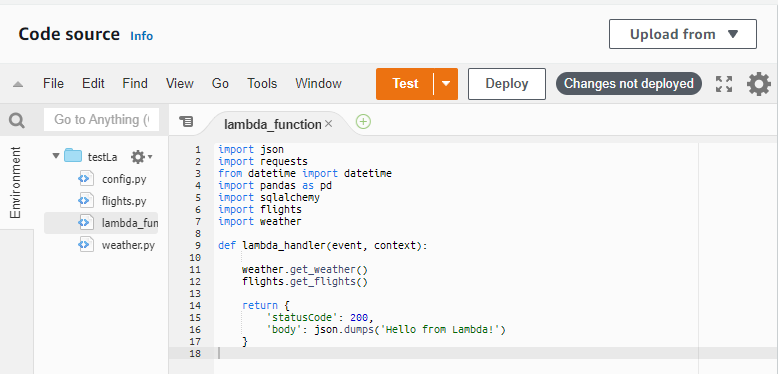

After setting up the ```lambda_handler()``` as shown in the image above, the ```weather.py``` script and the ```flights.py``` script are now uploaded together with the ```lambda_handler()``` as a *.zip*-file. The function should be operational after the deployment of the code.

### 6. Schedule the scripts to be executed periodically

For this purpose, a simple time switch is enough. With the button **Add trigger** a so called "EventBridge" can be set up which allows a periodic execution in arbitrary intervals. This specific function is executed every 24 hours.

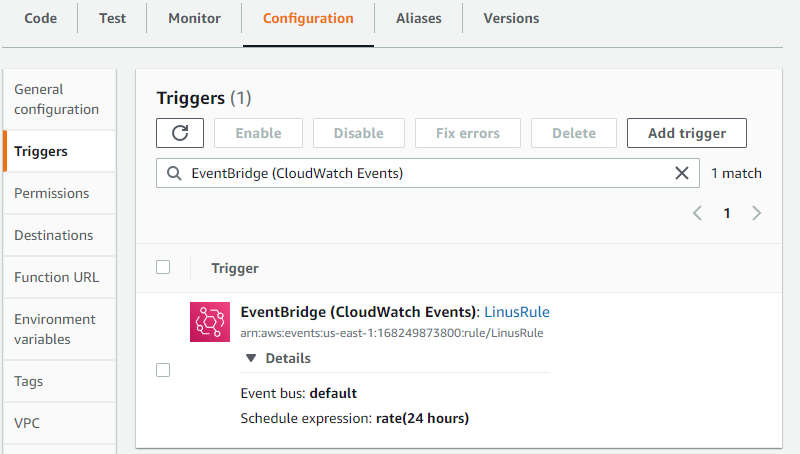

## Project Summary

This project is something of a pilot for Gans. Until the offer is fully implemented for all relevant cities, the database still needs to be expanded to include the respective data. However, the underlying system is now operational and easily expandable. In its current state, the system records all arriving and departing flights at Porto Airport in conjunction with the expected weather. This data allows Gans to make a forecast of expected customer traffic.